In [1]:
import h5py, os, pickle
from importlib import reload
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from matplotlib import cm
from imp import reload

from ecog.utils import bands
from cv_paper_plots.style import (subject_colors, letter_fontstyle,
                                  ticklabel_fontstyle, subject_labels)

import scipy as sp
from cv_paper_plots import xfreq_analysis as xfa
from cv_paper_plots import broadband
from cv_paper_plots.xfreq_analysis import good_examples_and_channels
from cv_paper_plots.broadband import (forward_bl, invert_bl, new_ch_idx, get_pcs, flip,
                                      baseline_mean_std, plot_PC1s, load_data)

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

/home/jesse/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Load data

In [2]:
folder = os.path.join(os.environ['HOME'],'Development/data/ecog/AA_ff/')
subjects = ['ec2', 'ec9', 'gp31', 'gp33']
files = ['EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'EC9_blocks_15_39_46_49_53_60_63_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP31_blocks_1_2_4_6_9_21_63_65_67_69_71_78_82_83_CV_AA_ff_align_window_-0.5_to_0.79_none.h5',
         'GP33_blocks_1_5_30_CV_AA_ff_align_window_-0.5_to_0.79_none.h5']
freqs = bands.chang_lab['cfs']

In [3]:
subject_idx = 0
subject = subjects[subject_idx]

In [8]:
folder = '/storage/ecog/AA_ff/'
files = ['','EC9_blocks_15_39_46_49_53_60_63_CV_AA_ff_align_window_-0.5_to_0.79_file.h5',
         '', '']

In [4]:
folder = '/storage/ecog/AA_ff2/'
files = ['EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none_random_phase.h5',
         '', '', '']

In [5]:
os.path.join(folder, files[subject_idx])

'/storage/ecog/AA_ff2/EC2_blocks_1_8_9_15_76_89_105_CV_AA_ff_align_window_-0.5_to_0.79_none.h5'

In [4]:
fname = os.path.join(folder, files[subject_idx])
X, baselines, good_examples, good_channels, tokens, block_labels, labels = load_data(fname)
bl_mean, bl_std = baseline_mean_std(block_labels, good_channels, baselines)
print(subject)
X.min(), X.max()

2572 85
ec2


(9.888741e-09, 0.040291335)

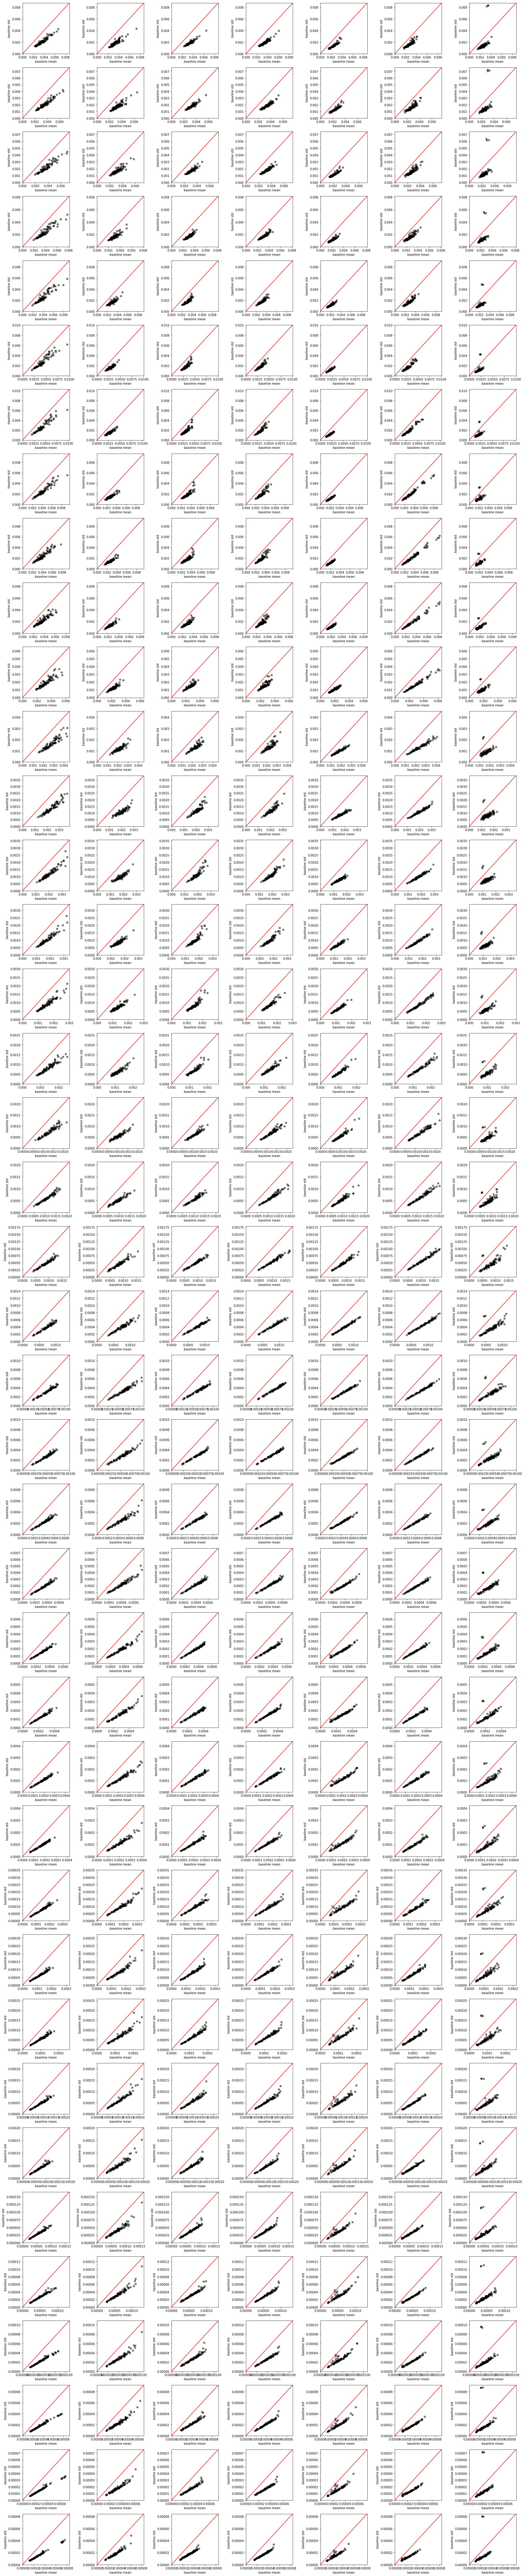

In [8]:
blocks = sorted(set(block_labels))
f, axes = plt.subplots(40, len(blocks), figsize=(len(blocks) * 3.5, 120))
for ii, ax_r in enumerate(axes):
    x = bl_mean[:, ii].ravel()
    y = bl_std[:, ii].ravel()
    size = 1.05 * max(x.max(), y.max())
    for jj, b in enumerate(blocks):
        ax = ax_r[jj]
        x = bl_mean[jj, ii].ravel()
        y = bl_std[jj, ii].ravel()
        if jj > 0:
            x = x
            y = y
        ax.scatter(x, y, c='k', alpha=.5)
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xlabel('baseline mean')
        ax.set_ylabel('baseline std')
        #ax.axis('equal')
        ax.plot([0, size], [0, size], c='r')
f.tight_layout()

In [7]:
bl_type = 'bl_zscore'
X, bl_type_mean = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)

In [11]:
bl_type = 'bl_zscore'
X = invert_bl(X, bl_type, bl_type_mean, bl_mean, bl_std, block_labels)

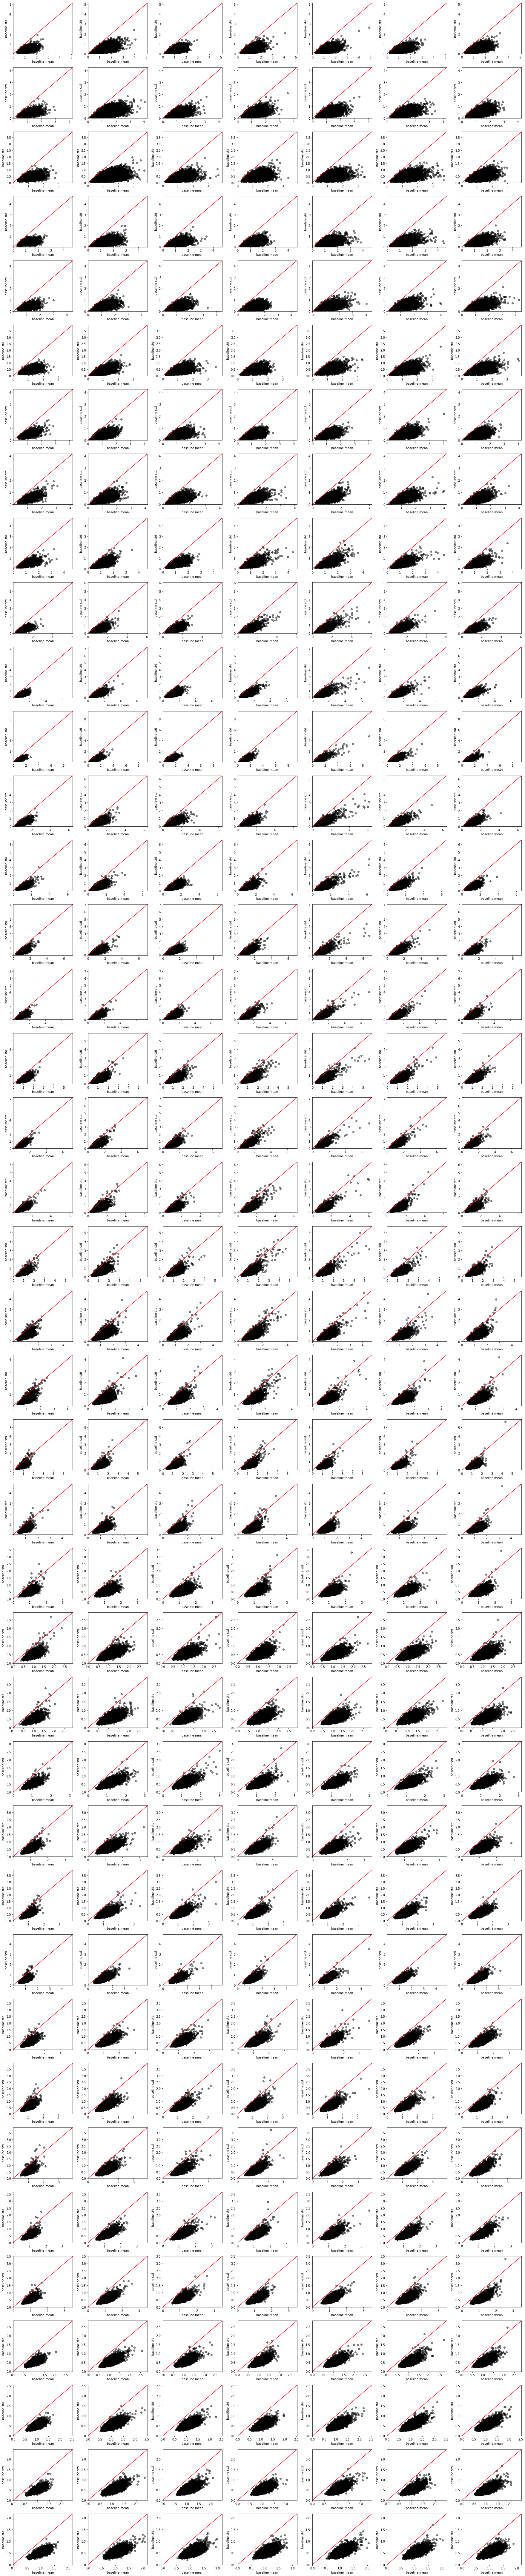

In [14]:
blocks = sorted(set(block_labels))
f, axes = plt.subplots(40, len(blocks), figsize=(len(blocks) * 3.5, 120))
for ii, ax_r in enumerate(axes):
    data = X[ii]
    for jj, b in enumerate(blocks):
        idxs = np.where(block_labels == b)[0]
        data[idxs] /= bl_mean[jj, ii][np.newaxis, :, np.newaxis]
    x = data.mean(axis=-1)
    y = data.std(axis=-1)
    size = 1.05 * max(x.max(), y.max())
    for jj, b in enumerate(blocks):
        idxs = np.where(block_labels == b)[0]
        ax = ax_r[jj]
        data2 = data[idxs]
        x = data2.mean(axis=-1).ravel()
        y = data2.std(axis=-1).ravel()
        if jj > 0:
            x = x * 1.
            y = y * 1.
        ax.scatter(x, y, c='k', alpha=.5)
        ax.set_xlim(0, size)
        ax.set_ylim(0, size)
        ax.set_xlabel('baseline mean')
        ax.set_ylabel('baseline std')
        #ax.axis('equal')
        ax.plot([0, size], [0, size], c='r')
f.tight_layout()

# Power spectra

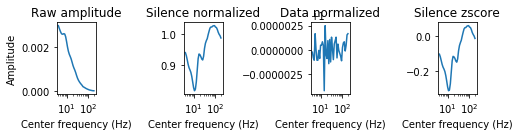

In [9]:
f, axes = plt.subplots(1, 4, figsize=(7, 2), sharex=True)
titles = ['Raw amplitude', 'Silence normalized', 'Data normalized', 'Silence zscore']
for ii, bl_type in enumerate([None, 'bl_mean', 'data_mean', 'bl_zscore']):
    axes[ii].set_title(titles[ii])
    if bl_type is not None:
        X, bl_type_mean = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
    axes[ii].plot(bands.chang_lab['cfs'], X.mean(axis=(1, 2, 3)))
    if bl_type is not None:
        X = invert_bl(X, bl_type, bl_type_mean, bl_mean, bl_std, block_labels)
    axes[ii].set_xscale('log')
axes[0].set_ylabel('Amplitude')
for ax in axes:
    ax.set_xlabel('Center frequency (Hz)')
    
#for ax in axes:
#    ax.set_ylim(0, None)
f.tight_layout()
#plt.savefig(os.path.join(os.environ['HOME'],
#                         'Downloads/{}_power_spectra.pdf'.format(subject)))

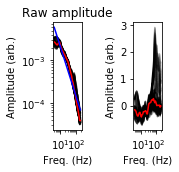

In [9]:
f, axes = plt.subplots(1, 2, figsize=(6, 2.5))
ax = axes.ravel()[0]
cv = np.where(np.array(tokens) == 'gaa')[0]
ch = 103
x = np.tile(bands.chang_lab['cfs'][:, np.newaxis], (1, 258))
y = X[:, labels==cv, new_ch_idx(ch, good_channels)].mean(axis=1)
ax.plot(x, y, c='k', alpha=.1)
ax.plot(x[:, 0], np.median(y, axis=1), c='red', label='median')
model = RANSACRegressor().fit(np.log(x.T).ravel()[:, np.newaxis], np.log(y.T).ravel())
yp = np.exp(model.estimator_.coef_ * np.log(x[:, 0]) + model.estimator_.intercept_)
ax.plot(x[:, 0], yp, c='blue', label='RANSAC Regression')
ax.set_title('Raw amplitude')
ax.set_yscale('log')

ax = axes.ravel()[1]
bl_type = 'bl_zscore'
X, bl_type_mean = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
x = np.tile(bands.chang_lab['cfs'][:, np.newaxis], (1, 258))
y = X[:, labels==cv, new_ch_idx(ch, good_channels)].mean(axis=1)
ax.plot(x, y, c='k', alpha=.1)
ax.plot(x[:, 0], np.median(y, axis=1), c='red', label='median')
X = invert_bl(X, bl_type, bl_type_mean, bl_mean, bl_std, block_labels)
#ax.set_title('Silence zscored')
for ax in axes.ravel():
    ax.set_xscale('log')
    ax.set_ylabel('Amplitude (arb.)')
    ax.set_xlabel('Freq. (Hz)')
#    ax.legend(loc='best')
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_spects.pdf'.format(subject)))

# PCA

In [12]:
X[X <= 0] = X[X > 0].min()
rng = np.random.RandomState(20180917)

pcs = np.full((2, 2, 2, len(good_channels), 3, 40), np.nan)
evs = np.full((2, 2, 2, len(good_channels), 3), np.nan)

means = np.full((2, 2, 2, len(good_channels), 40), np.nan)

pcs_s = np.full((2, 2, 2, len(good_channels), 3, 40), np.nan)
evs_s = np.full((2, 2, 2, len(good_channels), 3), np.nan)

for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    X, bl_type_means = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
    for ch in range(len(good_channels)):
        d = X[:, :, ch].reshape(40, -1).T
        for jj, center_pca in enumerate([True, False]):
            for kk, log in enumerate([True, False]):
                if log:
                    dp = np.log(d)
                else:
                    dp = d
                dp_s = np.zeros_like(dp)
                for nn in range(dp.shape[1]):
                    dp_s[:, nn] = rng.permutation(dp[:, nn])
                (w, v), m = get_pcs(dp, center_pca)
                pcs[ii, jj, kk, ch] = v[:, ::-1].T
                evs[ii, jj, kk, ch] = w[::-1]
                means[ii, jj, kk, ch] = m
                (w_s, v_s), _ = get_pcs(dp_s, center_pca)
                pcs_s[ii, jj, kk, ch] = v_s[:, ::-1].T
                evs_s[ii, jj, kk, ch] = w_s[::-1]
    X = invert_bl(X, bl_type, bl_type_means, bl_mean, bl_std, block_labels)

pcs = flip(pcs)
pcs_s = flip(pcs_s)

In [16]:
np.savez('{}_pca_analysis_random_phase'.format(subject), pcs=pcs, evs=evs, means=means, pcs_s=pcs_s, evs_s=evs_s,
         axes=['bl_type', 'center_pca', 'log'])

In [17]:
d = np.load('{}_pca_analysis_random_phase.npz'.format(subject))
pcs = d['pcs']
evs = d['evs']
pcs_s = d['pcs_s']
evs_s = d['evs_s']
means = d['means']

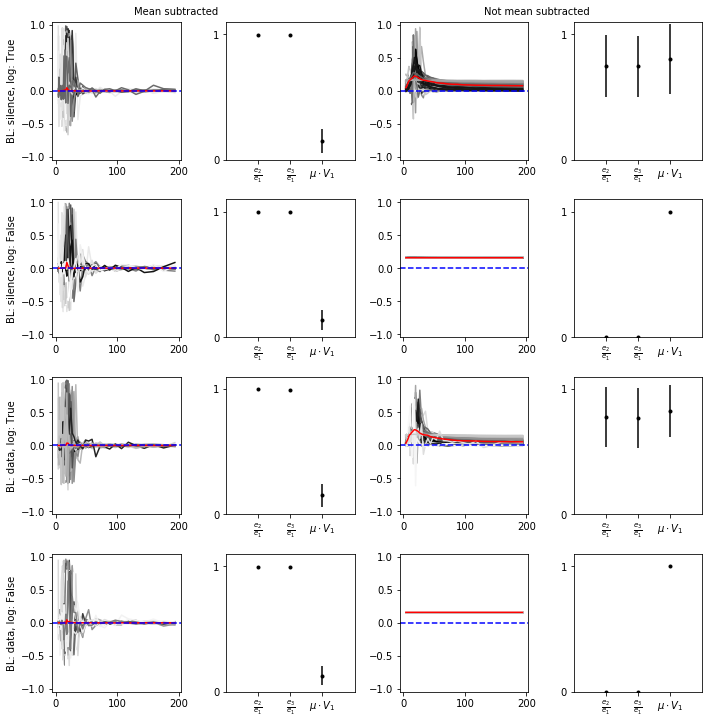

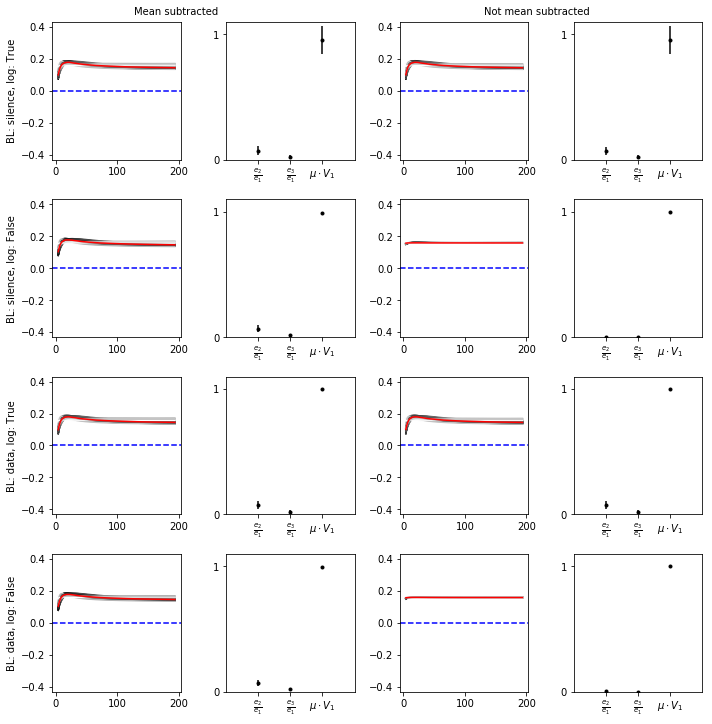

In [18]:
bl_names = ['BL: silence', 'BL: data']
for sampled in [True, False]:
    f, axes = plt.subplots(4, 4, figsize=(10, 10))
    row = 0
    for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
        for kk, log in enumerate([True, False]):
            row_ax = axes[row]
            for jj, center_pca in enumerate([True, False]):
                if row == 0:
                    title=True
                else:
                    title=False
                if jj == 0:
                    ylabel = '{}, log: {}'.format(bl_names[ii], log)
                else:
                    ylabel = None
                if sampled:
                    these_pcs = pcs_s[ii, jj, kk]
                    these_evs = evs_s[ii, jj, kk]
                else:
                    these_pcs = pcs[ii, jj, kk]
                    these_evs = evs[ii, jj, kk]
                these_mean = means[ii, jj, kk]
                axs = row_ax[jj * 2:jj * 2 +2]
                plot_PC1s(these_pcs, these_evs, these_mean,
                          (f, (axs)), title=title, ylabel=ylabel)
            row += 1
    f.text(.25, .99, 'Mean subtracted', ha='center')
    f.text(.75, .99, 'Not mean subtracted', ha='center')
    if sampled:
        max_val = 1.05 * abs(pcs_s).max()
    else:
        max_val = 1.05 * abs(pcs).max()
    for ii, ax in enumerate(axes.ravel()):
        if (ii % 2) == 0:
            ax.set_ylim(-max_val, max_val)
    f.tight_layout()
    if sampled:
        plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s_sampled_random_phase.pdf'.format(subject)))
    else:
        plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_PC1s_random_phase.pdf'.format(subject)))

In [10]:
def plot_103_106(pcs, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(1, 2, figsize=(10, 3))
    f, axes = faxes
    for ax, ch in zip(axes, [103, 106]):
        if title:
            ax.set_title('Electrode: {}'.format(ch))
        for ii in range(3):
            ax.plot(freqs, pcs[new_ch_idx(ch, good_channels), ii], label=ii)
        ax.legend()
        ax.set_xscale('log')
    if ylabel is not None:
        axes[0].set_ylabel(ylabel)
    return

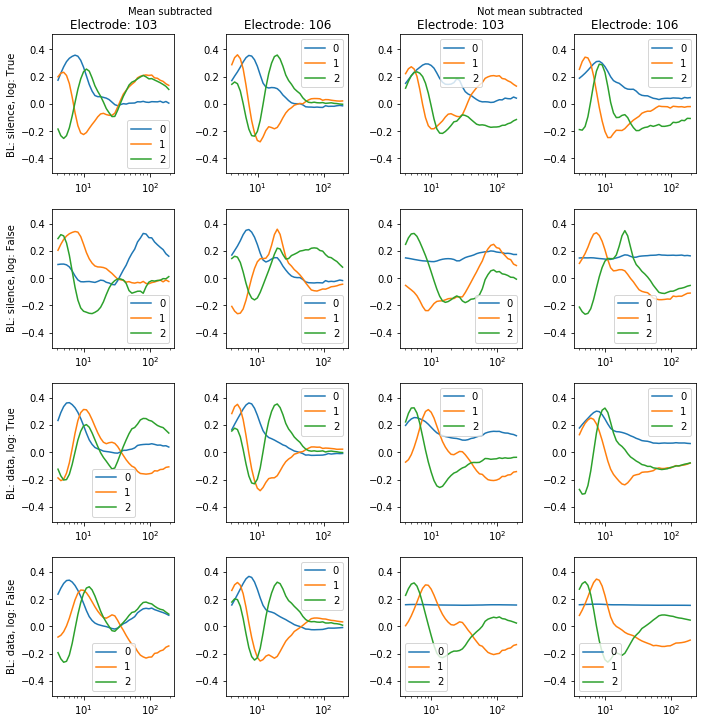

In [60]:
f, axes = plt.subplots(4, 4, figsize=(10, 10))
row = 0
for ii, bl_type in enumerate(['bl_mean', 'data_mean']):
    for kk, log in enumerate([True, False]):
        row_ax = axes[row]
        for jj, center_pca in enumerate([True, False]):
            if row == 0:
                title=True
            else:
                title=False
            if jj == 0:
                ylabel = '{}, log: {}'.format(bl_names[ii], log)
            else:
                ylabel = None
            these_pcs = pcs[ii, jj, kk]
            axs = row_ax[jj * 2:jj * 2 +2]
            plot_103_106(these_pcs, (f, (axs)), title=title, ylabel=ylabel)
        row += 1
f.text(.25, .99, 'Mean subtracted', ha='center')
f.text(.75, .99, 'Not mean subtracted', ha='center')
max_val = 1.05 * abs(pcs).max()
for ax in axes.ravel():
    ax.set_ylim(-max_val, max_val)
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/{}_103_106.pdf'.format(subject)))

# P1

In [6]:
rng = np.random.RandomState(20180917)

pcs = np.full((2, len(good_channels), 3, 40), np.nan)
evs = np.full((2, len(good_channels), 3), np.nan)

means = np.full((2, len(good_channels), 40), np.nan)

pcs_s = np.full((2, len(good_channels), 3, 40), np.nan)
evs_s = np.full((2, len(good_channels), 3), np.nan)

bl_type = 'bl_zscore'
X, bl_type_means = forward_bl(X, bl_type, bl_mean, bl_std, block_labels)
for ch in range(len(good_channels)):
    d = X[:, :, ch].reshape(40, -1).T
    for jj, center_pca in enumerate([True, False]):
        dp = d
        dp_s = np.zeros_like(dp)
        for nn in range(dp.shape[1]):
            dp_s[:, nn] = rng.permutation(dp[:, nn])
        (w, v), m = get_pcs(dp, center_pca)
        pcs[jj, ch] = v[:, ::-1].T
        evs[jj, ch] = w[::-1]
        means[jj, ch] = m
        (w_s, v_s), _ = get_pcs(dp_s, center_pca)
        pcs_s[jj, ch] = v_s[:, ::-1].T
        evs_s[jj, ch] = w_s[::-1]
X = invert_bl(X, bl_type, bl_type_means, bl_mean, bl_std, block_labels)

pcs = flip(pcs)
pcs_s = flip(pcs_s)

In [8]:
np.savez('{}_pca_analysis_zscore'.format(subject), pcs=pcs, evs=evs,
         means=means, axes=['center_pca'])

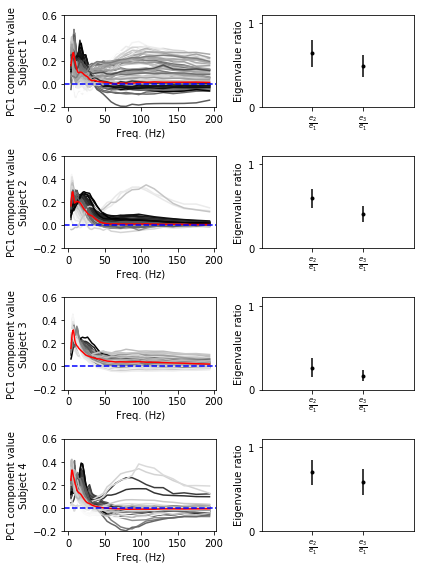

In [11]:
f, axes = plt.subplots(4, 2, figsize=(6, 8))
for ii, subject in enumerate(subjects):
    ax = axes[ii]
    d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
    pcs = d['pcs']
    evs = d['evs']
    #means = d['means']
    plot_PC0s(pcs[0], evs[0], None, faxes=(f, ax))
    ax[0].set_ylabel('PC1 component value\n{}'.format(subject_labels[subject]))
for ax in axes[:, 0]:
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.2, .6)
for ax in axes[:, 1]:
    ax.set_ylabel('Eigenvalue ratio')
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/PC1s.pdf'))

In [74]:
d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
pcs = d['pcs']
evs = d['evs']
means = d['means']

In [19]:
beta = bands.chang_lab['cfs'] >= bands.neuro['min_freqs'][2]
beta = np.where(np.logical_and(beta, bands.chang_lab['cfs'] <= bands.neuro['max_freqs'][3]))
hg = bands.chang_lab['cfs'] >= bands.neuro['min_freqs'][-1]
hg = np.where(np.logical_and(hg, bands.chang_lab['cfs'] <= bands.neuro['max_freqs'][-1]))

[0.01754386 0.01754386 0.01754386 0.01754386 0.42105263 0.56140351
 0.14035088 0.42105263 0.73684211 0.01754386 0.03508772 0.03508772
 0.05263158 0.1754386  0.71929825 0.9122807  1.         0.03508772
 0.22807018 0.35087719 0.03508772 0.05263158 1.         0.8245614
 0.14035088 0.03508772 1.         0.21052632 0.01754386 0.07017544
 0.21052632 0.0877193  0.52631579]


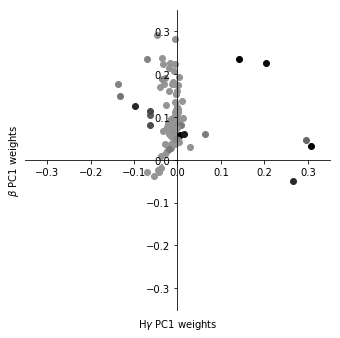

In [75]:
cv_channels = np.load(os.path.join(os.environ['HOME'], 'plots/xfreq/data',
                                  '{}_hg_power_cutoff.npz'.format(subject)))['cv_channels']
active_frac = cv_channels.mean(axis=0)
print(active_frac[active_frac> 0])

f, ax = plt.subplots(1, figsize=(5, 5))
bw = pcs[0, :, 0][:, beta].mean(axis=-1).ravel()
hgw = pcs[0, :, 0][:, hg].mean(axis=-1).ravel()
for ii in range(active_frac.size):
    ax.scatter(hgw[ii], bw[ii], c=cm.Greys(.5 + active_frac[ii]/2))
ax.set_xlabel(r'H$\gamma$ PC1 weights', labelpad=140)
ax.set_ylabel(r'$\beta$ PC1 weights', labelpad=125)
ax.set_xlim(-.35, .35)
ax.set_ylim(-.35, .35)
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')

f.tight_layout()
plt.savefig('/home/jesse/Downloads/{}_hg_vs_b.pdf'.format(subject))

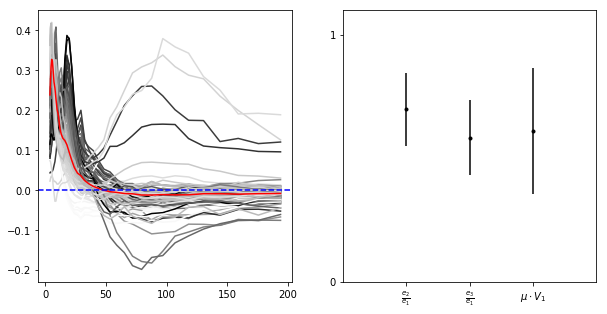

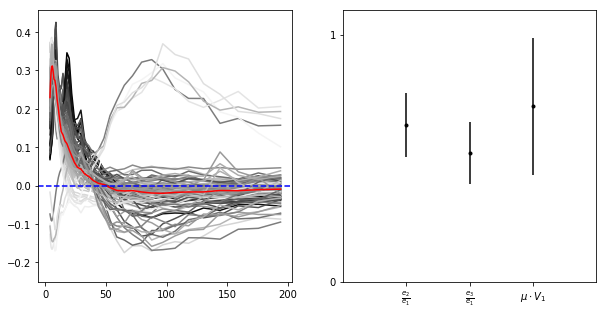

In [78]:
faxes = plt.subplots(1, 2, figsize=(10, 5))
plot_PC0s(pcs[0], evs[0], means[0], faxes=faxes)
faxes = plt.subplots(1, 2, figsize=(10, 5))
plot_PC0s(pcs[1], evs[1], means[1], faxes=faxes)

# Cluster

In [34]:
def cluster_PC0s(pcs, n_clusters=3, faxes=None, title=False, ylabel=None):
    if faxes is None:
        faxes = plt.subplots(n_clusters)
    f, axes = faxes
    beta_weights = np.zeros(pcs.shape[0])
    beta_weights = (pcs[:, 0, 14:20]).sum(axis=-1)
    print(pcs.shape[0])
    beta_weights -= beta_weights.min()
    beta_weights /= beta_weights.max()
    model = KMeans(n_clusters=n_clusters)
    y = model.fit_predict(pcs[:, 0])
    print(pcs.shape)
    for ii, pc0 in enumerate(pcs[:, 0]):
        yi = y[ii]
        axes[yi].plot(freqs, pc0 ,c=cm.Greys(beta_weights[ii]), alpha=1.)
    for ii, ax in enumerate(axes):
        ax.plot(freqs, np.median(pcs[y == ii, 0], axis=0), c='r')
        ax.axhline(0, 0, 1, c='blue', ls='--')
    return

85
(85, 3, 40)


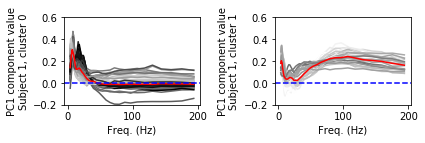

In [47]:
subject = 'ec2'
d = np.load('{}_pca_analysis_zscore.npz'.format(subject))
pcs = d['pcs']
n_clusters = 2
faxes = plt.subplots(1, n_clusters, figsize=(3*n_clusters, 2))
cluster_PC0s(pcs[0], n_clusters=n_clusters, faxes=faxes)
f, axes = faxes
for ii, ax in enumerate(axes.ravel()):
    ax.set_xlabel('Freq. (Hz)')
    ax.set_ylim(-.2, .6)
    ax.set_ylabel('PC1 component value\n{}, cluster {}'.format(subject_labels[subject], ii))
f.tight_layout()
plt.savefig(os.path.join(os.environ['HOME'], 'Downloads/Subject1_PC1s.pdf'))